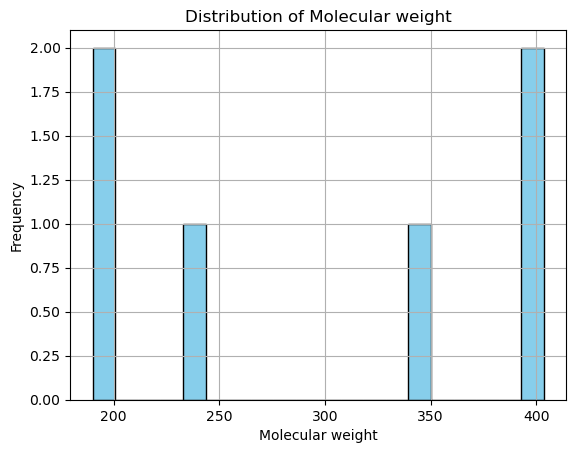

,Molecule Name,ABC,SMILES,Molecular weight,TPSA,logP,H Acceptors,H Donors,Ring Count,LipinskiPass
0,D-0011822,ABC-2436044,Clc1ccc2Oc3c([C@@H]4CN(C)C[C@H]4c2c1)cccc3.O=C...,401.846,87.07,3.97030,4,2,4,True
1,D-0011823,ABC-2436045,S(C)(O)(=O)=O.O(C(c1ccccc1)c1ccccc1)[C@H]1C[C@...,403.544,66.84,3.92180,4,1,4,True
2,D-0011829,ABC-2436051,Brc1cc2c(cc(cc2)C(=O)c2c(Cl)cccc2)cc1,345.623,17.07,5.48670,1,0,3,False
3,D-0011830,ABC-2436052,Brc1c(C)cc(C(Cl)=O)cc1,233.492,17.07,3.13652,1,0,1,True
4,D-0011832,ABC-2436054,FC(F)(F)c1cc(C=O)ccc1O,190.120,37.30,2.22350,2,1,1,True
5,D-0011832,test,FC(F)(F)c1cc(C=O)ccc1O,190.120,37.30,2.22350,2,1,1,True


In [36]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor


class ProcessMolDf:
    def __init__(self, df):
        self.df = df
    
    @staticmethod
    def _calculate_mol_props(smiles, prop_func):
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return prop_func(mol)
        else:
            return None
    
    def add_mol_props_columns(self, mol_props_funcs):
        with ThreadPoolExecutor() as executor:
            futures = []
            for prop_name, prop_func in mol_props_funcs.items():
                futures.append(executor.submit(self._calculate_mol_props_column, prop_name, prop_func))
            for future in futures:
                future.result()
    
    def _calculate_mol_props_column(self, prop_name, prop_func):
        self.df[prop_name] = self.df['SMILES'].apply(lambda x: self._calculate_mol_props(x, prop_func))
    
    def check_lipinski(self):
        self.df['LipinskiPass'] = (self.df['Molecular weight'] < 500) & (self.df['logP'] < 5) & (self.df['H Donors'] < 5) & (self.df['H Acceptors'] < 10)

    def plot_property_distribution(self, prop_name):
        plt.hist(self.df[prop_name].dropna(), bins=20, color='skyblue', edgecolor='black')
        plt.title(f'Distribution of {prop_name}')
        plt.xlabel(prop_name)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()



df = pd.read_csv("test_file.csv")

mol_props_funcs = {
    "Molecular weight": lambda mol: Descriptors.MolWt(mol),
    "TPSA": lambda mol: Descriptors.TPSA(mol),
    "logP": lambda mol: Descriptors.MolLogP(mol),
    "H Acceptors": lambda mol: Descriptors.NumHAcceptors(mol),
    "H Donors": lambda mol: Descriptors.NumHDonors(mol),
    "Ring Count": lambda mol: Descriptors.RingCount(mol),
}


processor = ProcessMolDf(df)

processor.add_mol_props_columns(mol_props_funcs)

processor.check_lipinski()

processor.plot_property_distribution('Molecular weight')

df


In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from concurrent.futures import ThreadPoolExecutor

class MolecularPropertiesAnalyzer:
    def __init__(self, file_path, chunk_size=100):
        self.df = pd.read_csv(file_path)
        self.chunk_size = chunk_size
        self.mol_props_funcs = {
            "Molecular weight": lambda mol: Descriptors.MolWt(mol),
            "TPSA": lambda mol: Descriptors.TPSA(mol),
            "logP": lambda mol: Descriptors.MolLogP(mol),
            "H Acceptors": lambda mol: Descriptors.NumHAcceptors(mol),
            "H Donors": lambda mol: Descriptors.NumHDonors(mol),
            "Ring Count": lambda mol: Descriptors.RingCount(mol),
            "Lipinski pass": lambda mol: all([
                Descriptors.MolWt(mol) < 500,
                Descriptors.MolLogP(mol) < 5,
                Descriptors.NumHDonors(mol) < 5,
                Descriptors.NumHAcceptors(mol) < 10
            ])
        }

    def process_chunk(self, chunk):
        for idx, row in chunk.iterrows():
            mol = Chem.MolFromSmiles(row['clean_smiles'])
            if mol is not None:
                for prop, func in self.mol_props_funcs.items():
                    chunk.at[idx, prop] = func(mol)
            else:
                print(f"Unable to process molecule {idx + 1}")

    def calculate_properties(self):
        num_chunks = len(self.df) // self.chunk_size + 1
        with ThreadPoolExecutor() as executor:
            futures = []
            for i in range(num_chunks):
                start = i * self.chunk_size
                end = (i + 1) * self.chunk_size
                chunk = self.df.iloc[start:end]
                futures.append(executor.submit(self.process_chunk, chunk))
            for future in futures:
                future.result()

    def display_dataframe(self):
        print(self.df)


analyzer = MolecularPropertiesAnalyzer('HUGE_Data_Set.csv', chunk_size=1000)
analyzer.calculate_properties()
analyzer.display_dataframe()